<a href="https://colab.research.google.com/github/Sanjay2003ms/Chatbot-Backend/blob/main/Welcome_To_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!unzip NasaBearing.zip


Archive:  NasaBearing.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of NasaBearing.zip or
        NasaBearing.zip.zip, and cannot find NasaBearing.zip.ZIP, period.


In [5]:
!ls


NasaBearing.zip  sample_data


In [9]:
!ls NasaBearing.zip


NasaBearing.zip


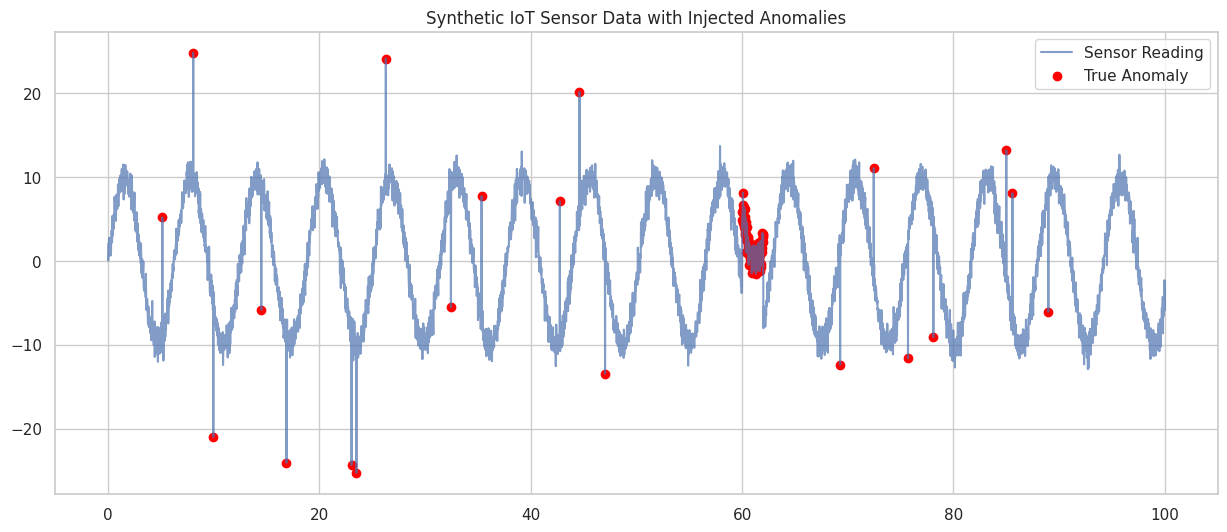

Total Data Points: 5000
Anomaly Ratio: 0.0240


In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, confusion_matrix

# TensorFlow/Keras for the Deep Learning approach
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Dropout

# Config for plots
sns.set(style="whitegrid")
np.random.seed(42)
tf.random.set_seed(42)

def generate_sensor_data(n_points=5000):
    """
    Generates synthetic sensor data with seasonality, noise, and anomalies.
    """
    t = np.linspace(0, 100, n_points)

    # 1. Base Signal (Sine wave for seasonality)
    signal = 10 * np.sin(t)

    # 2. Add Noise
    noise = np.random.normal(0, 1, n_points)

    # 3. Construct Data
    data = signal + noise

    # 4. Inject Anomalies
    labels = np.zeros(n_points)

    # Type A: Point Anomalies (Sudden Spikes)
    anomaly_indices_1 = np.random.choice(range(n_points), size=20, replace=False)
    data[anomaly_indices_1] += np.random.choice([15, -15], size=20) # Huge spikes
    labels[anomaly_indices_1] = 1

    # Type B: Contextual Anomalies (Sensor Drift/Failure over a period)
    # Let's say the sensor gets stuck or drifts between index 3000 and 3100
    data[3000:3100] = data[3000:3100] + 10  # Sudden shift in mean
    labels[3000:3100] = 1

    df = pd.DataFrame({'timestamp': t, 'sensor_value': data, 'is_anomaly': labels})
    return df

# Initialize Data
df = generate_sensor_data()

# 1.1 Exploratory Data Analysis (EDA)
plt.figure(figsize=(15, 6))
plt.plot(df['timestamp'], df['sensor_value'], label='Sensor Reading', alpha=0.7)
plt.scatter(df[df['is_anomaly']==1]['timestamp'], df[df['is_anomaly']==1]['sensor_value'], color='red', label='True Anomaly')
plt.title("Synthetic IoT Sensor Data with Injected Anomalies")
plt.legend()
plt.show()

print(f"Total Data Points: {len(df)}")
print(f"Anomaly Ratio: {df['is_anomaly'].mean():.4f}")

In [13]:
def feature_engineering(df):
    df_feat = df.copy()

    # Rolling Statistics (Window = 50 time steps)
    df_feat['rolling_mean'] = df_feat['sensor_value'].rolling(window=10).mean()
    df_feat['rolling_std'] = df_feat['sensor_value'].rolling(window=10).std()

    # Lag Features (Previous values)
    df_feat['lag_1'] = df_feat['sensor_value'].shift(1)
    df_feat['lag_5'] = df_feat['sensor_value'].shift(5)

    # Fill NaN created by rolling/shifting
    df_feat.fillna(method='bfill', inplace=True)

    return df_feat

df_engineered = feature_engineering(df)

# Scaling (CRITICAL for Distance-based and DL models)
features_to_use = ['sensor_value', 'rolling_mean', 'rolling_std', 'lag_1', 'lag_5']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_engineered[features_to_use])

# Split for Training (Train on "mostly normal" data usually, but here we split sequentially)
train_size = int(len(df) * 0.7)
X_train = X_scaled[:train_size]
X_test = X_scaled[train_size:]
y_test = df['is_anomaly'].iloc[train_size:]

/tmp/ipython-input-3904293931.py:13: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_feat.fillna(method='bfill', inplace=True)


In [14]:
def train_isolation_forest(X_train, X_test, contamination=0.02):
    """
    Train Isolation Forest.
    Contamination is an important hyperparameter: estimated % of anomalies.
    """
    iso_forest = IsolationForest(contamination=contamination, random_state=42)
    iso_forest.fit(X_train)

    # Predict (-1 is anomaly, 1 is normal in sklearn)
    preds_train = iso_forest.predict(X_train)
    preds_test = iso_forest.predict(X_test)

    # Map -1 to 1 (anomaly) and 1 to 0 (normal) to match our labels
    preds_test_mapped = [1 if x == -1 else 0 for x in preds_test]

    return preds_test_mapped, iso_forest

# Run Approach 1
y_pred_if, model_if = train_isolation_forest(X_train, X_test, contamination=0.03)

print("--- Isolation Forest Results ---")
print(classification_report(y_test, y_pred_if))

--- Isolation Forest Results ---
              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99      1494
         1.0       0.22      1.00      0.36         6

    accuracy                           0.99      1500
   macro avg       0.61      0.99      0.68      1500
weighted avg       1.00      0.99      0.99      1500



In [15]:
def create_sequences(data, time_steps=30):
    output = []
    for i in range(len(data) - time_steps + 1):
        output.append(data[i : (i + time_steps)])
    return np.stack(output)

# Prepare 3D Data
TIME_STEPS = 30
X_train_seq = create_sequences(X_train, TIME_STEPS)
X_test_seq = create_sequences(X_test, TIME_STEPS)

# Update y_test to match sequence length (loss of first TIME_STEPS rows)
y_test_seq = y_test.iloc[TIME_STEPS-1:].values

def build_lstm_autoencoder(input_shape):
    model = Sequential()
    # Encoder
    model.add(LSTM(64, activation='relu', input_shape=input_shape, return_sequences=True))
    model.add(LSTM(32, activation='relu', return_sequences=False))
    model.add(RepeatVector(input_shape[0])) # Bridge encoder to decoder
    # Decoder
    model.add(LSTM(32, activation='relu', return_sequences=True))
    model.add(LSTM(64, activation='relu', return_sequences=True))
    model.add(TimeDistributed(Dense(input_shape[1]))) # Output layer

    model.compile(optimizer='adam', loss='mse')
    return model

# Train
model_lstm = build_lstm_autoencoder((X_train_seq.shape[1], X_train_seq.shape[2]))
history = model_lstm.fit(
    X_train_seq, X_train_seq, # Autoencoder maps Input -> Input
    epochs=20,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)

# Detect Anomalies based on Reconstruction Error (MAE)
X_test_pred = model_lstm.predict(X_test_seq)
test_mae_loss = np.mean(np.abs(X_test_pred - X_test_seq), axis=1) # Average error per sequence
test_mae_loss = np.mean(test_mae_loss, axis=1) # Reduce to single value per sample

# Determine Threshold (e.g., Mean + 3*STD of training loss, or a percentile)
# Here we use the 95th percentile of the reconstruction error
THRESHOLD = np.percentile(test_mae_loss, 95)

y_pred_lstm = [1 if e > THRESHOLD else 0 for e in test_mae_loss]

print("\n--- LSTM Autoencoder Results ---")
print(classification_report(y_test_seq, y_pred_lstm))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 19s 83ms/step - loss: 0.7607 - val_loss: 0.2156
Epoch 2/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - loss: 0.2738 - val_loss: 0.1572
Epoch 3/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 7s 76ms/step - loss: 0.2151 - val_loss: 0.1437
Epoch 4/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 9s 67ms/step - loss: 0.1771 - val_loss: 0.1099
Epoch 5/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - loss: 0.1455 - val_loss: 0.0731
Epoch 6/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 7s 66ms/step - loss: 0.1105 - val_loss: 0.0682
Epoch 7/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 10s 60ms/step - loss: 0.0919 - val_loss: 0.0611
Epoch 8/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 7s 71ms/step - loss: 0.0806 - val_loss: 0.0555
Epoch 9/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - loss: 0.0783 - val_loss: 0.0507
Epoch 10/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 11s 65ms/step - loss: 0.0713 - val_loss: 0.0509
Epoch 11/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 7s 71ms/step - loss: 0.0678 - val_loss: 0.0500
Epoch 12/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 8s 78ms/step - loss: 

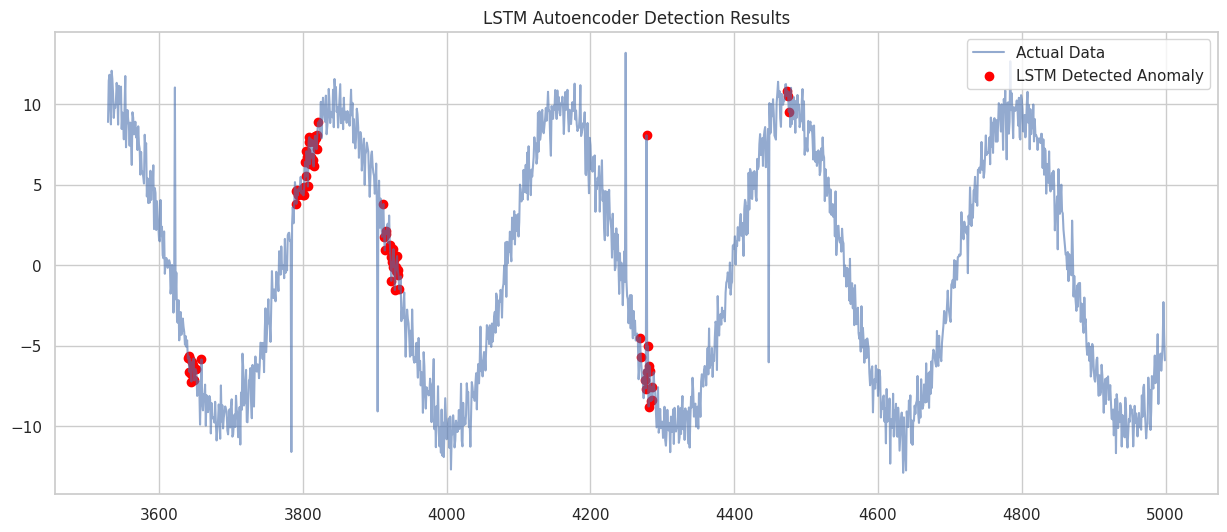

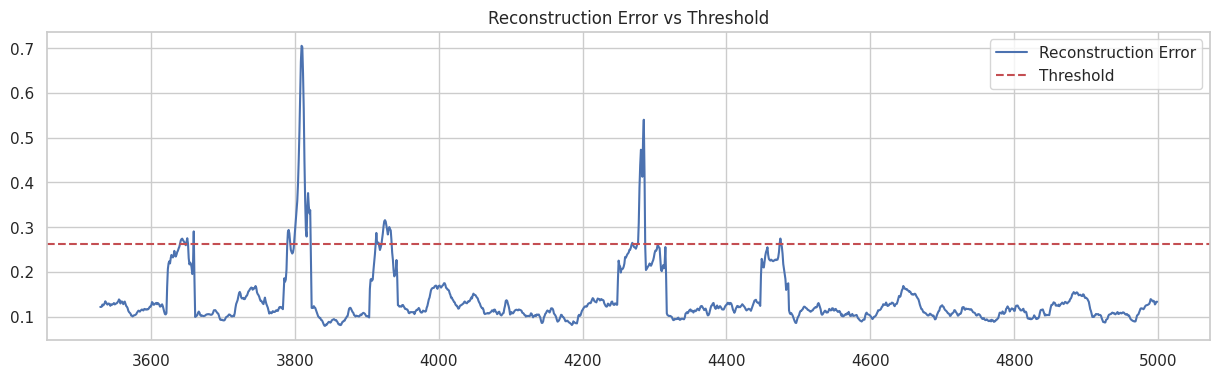

In [16]:
plt.figure(figsize=(15, 6))

# Align indices for plotting
test_indices = df.index[train_size + TIME_STEPS - 1 :]

plt.plot(test_indices, df.loc[test_indices, 'sensor_value'], label='Actual Data', alpha=0.6)
plt.scatter(test_indices[np.array(y_pred_lstm) == 1],
            df.loc[test_indices, 'sensor_value'][np.array(y_pred_lstm) == 1],
            color='red', label='LSTM Detected Anomaly')

plt.title("LSTM Autoencoder Detection Results")
plt.legend()
plt.show()

# Plot Reconstruction Error
plt.figure(figsize=(15, 4))
plt.plot(test_indices, test_mae_loss, label='Reconstruction Error')
plt.axhline(y=THRESHOLD, color='r', linestyle='--', label='Threshold')
plt.title("Reconstruction Error vs Threshold")
plt.legend()
plt.show()